In [1]:
import kagglehub
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from torch.utils.data import TensorDataset, DataLoader
import time

import torch
import torch.nn as nn
import torch.optim as optim
# Проверка версии PyTorch
print("Torch version:", torch.__version__)


# SGD 100 epoch -> 84.84%
# Adam 100 epcoch -> 93.44%
# Adam + OneCycleLR 100 epoch -> 89.86% (too slow!)
# Adam + high lw (0.01) 100 epoch -> 97.76% !!!!!!!!!!!
# Adam + very high lw (0.1) 100 epoch -> 93.76% (not stability in start)
# Adam + high lw (0.01) + StepLR (step_size=100) 200 epoch -> 97.97% (need stop in 120 epoch)


Torch version: 2.5.1


In [2]:
# path = kagglehub.dataset_download("hojjatk/mnist-dataset")

# print(path)
path = '/home/kayl/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1'

#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
# path = kagglehub.dataset_download("hojjatk/mnist-dataset")
class MnistDataloader:
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = np.array(array("B", file.read()))

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = np.array(array("B", file.read()))
        images = image_data.reshape(size, rows, cols)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

In [3]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = path
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [4]:
def show_image_train(index):
    if index >= 0 and index < len(x_train):
        plt.imshow(x_train[index], cmap=plt.cm.gray)
        plt.show()
    else:
        raise ValueError(f'incorrect index: {index}, max {len(x_train)}')
def show_image_test(index):
    if index >= 0 and index < len(x_test):
        plt.imshow(x_test[index], cmap=plt.cm.gray)
        plt.show()
    else:
        raise ValueError(f'incorrect index: {index}, max {len(x_test)}')

class Net1hidden(nn.Module):
    def __init__(self, L_input, L_hidden, L_output):
        super(Net1hidden, self).__init__()
        self.fc1 = nn.Linear(L_input, L_hidden)
        self.fc2 = nn.Linear(L_hidden, L_output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)

        x = x.view(-1, 64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
# For New1hidden
x_train_line = np.array([x_train[i].reshape(28*28) for i in range(len(x_train))])
X_train = torch.tensor(x_train_line / 255, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.int64)
x_test_line = np.array([x_test[i].reshape(28*28) for i in range(len(x_test))])
X_test = torch.tensor(x_test_line / 255, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.int64)

In [6]:
# # For CNN
# X_train = torch.tensor(x_train/255, dtype=torch.float32).unsqueeze(1)
# Y_train = torch.tensor(y_train, dtype=torch.int64)
# X_test = torch.tensor(x_test/255, dtype=torch.float32).unsqueeze(1)
# Y_test = torch.tensor(y_test, dtype=torch.int64)

# train_dataset = TensorDataset(X_train, Y_train)
# test_dataset = TensorDataset(X_test, Y_test)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [7]:
# model = CNN_2()
# criterion = nn.CrossEntropyLoss()  # Функция потерь для классификации
# # optimizer = optim.SGD(model.parameters(), lr=0.1)
# optimizer = optim.Adam(
#     model.parameters(), 
#     lr = 0.001, 
#     betas = (0.9, 0.999), 
#     eps=1e-8,
#     weight_decay=0.0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [8]:
L = 800
model = Net1hidden(28*28, L, 10)
criterion = nn.CrossEntropyLoss()  # Функция потерь для классификации
# optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(
    model.parameters(), 
    lr = 0.001, 
    betas = (0.9, 0.999), 
    eps=1e-8,
    weight_decay=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [9]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def test():
    model.eval()  
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
        return accuracy

In [10]:
epoch = 100
accuracies = []

start_time = time.time()
for epoch in range(1, epoch+1):
    train(epoch)
    acc = test()
    accuracies.append(acc)
    scheduler.step()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Time: {round(elapsed_time)} seconds')
    

Test set: Average loss: 0.0001, Accuracy: 9669/10000 (96.69%)
Time: 4 seconds
Test set: Average loss: 0.0001, Accuracy: 9701/10000 (97.01%)
Time: 7 seconds
Test set: Average loss: 0.0001, Accuracy: 9783/10000 (97.83%)
Time: 11 seconds
Test set: Average loss: 0.0001, Accuracy: 9799/10000 (97.99%)
Time: 15 seconds
Test set: Average loss: 0.0001, Accuracy: 9798/10000 (97.98%)
Time: 19 seconds
Test set: Average loss: 0.0001, Accuracy: 9799/10000 (97.99%)
Time: 23 seconds
Test set: Average loss: 0.0001, Accuracy: 9823/10000 (98.23%)
Time: 27 seconds
Test set: Average loss: 0.0001, Accuracy: 9821/10000 (98.21%)
Time: 31 seconds
Test set: Average loss: 0.0001, Accuracy: 9807/10000 (98.07%)
Time: 35 seconds
Test set: Average loss: 0.0001, Accuracy: 9813/10000 (98.13%)
Time: 39 seconds
Test set: Average loss: 0.0001, Accuracy: 9815/10000 (98.15%)
Time: 43 seconds
Test set: Average loss: 0.0001, Accuracy: 9835/10000 (98.35%)
Time: 47 seconds
Test set: Average loss: 0.0001, Accuracy: 9829/10000 (

ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

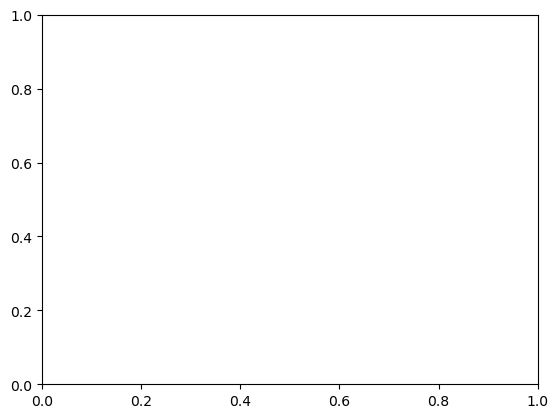

In [44]:
plt.plot(range(1, epoch+1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('MNIST')
plt.show()

In [16]:
PATH = "model_nn_adam.pth"
torch.save({
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'epoch' : 120,
    'loss' : loss,
}, PATH)

In [9]:
PATH = "model_nn_adam.pth"
checkpoint = torch.load(PATH)
_model = Net1hidden(28*28, 800, 10)
_model.load_state_dict(checkpoint['model_state_dict'])
_model.eval()

/tmp/ipykernel_8630/2728205505.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH)


Net1hidden(
  (fc1): Linear(in_features=784, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=10, bias=True)
)

In [12]:
_test, predicted_test = torch.max(_model(X_test), 1)  # Выбираем класс с наибольшим значением
correct_test = (predicted_test == Y_test).sum().item()
total_test = Y_test.size(0)
accuracy_test = correct_test / total_test
print(f'Accuracy on test set: {accuracy_test * 100:.2f}%')

Accuracy on test set: 98.00%


In [ ]:
for i in range(100):
    
    model.train()
    optimizer.zero_grad()
    outputs = model.forward(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test)
        outputs_train = model(X_train)
        _test, predicted_test = torch.max(outputs_test, 1)  # Выбираем класс с наибольшим значением
        _train, predicted_train = torch.max(outputs_train, 1)  # Выбираем класс с наибольшим значением
    
        # Сравниваем предсказания с истинными метками
        correct_test = (predicted_test == Y_test).sum().item()
        total_test = Y_test.size(0)
        correct_train = (predicted_train == Y_train).sum().item()
        total_train = Y_train.size(0)
        # Вычисляем точность
        accuracy_test = correct_test / total_test
        accuracy_train = correct_train / total_train
        arr_y_forGraph_test.append(accuracy_test)
        arr_y_forGraph_train.append(accuracy_train)
        print(f'{i} (epoch) Loss: {loss.item():.4f}, Accuracy on test set: {accuracy_test * 100:.2f}%', f'Accuracy on train set: {accuracy_train * 100:.2f}%')

In [ ]:
plt.plot([x*100 for x in arr_y_forGraph_test], label='test')
plt.plot([x*100 for x in arr_y_forGraph_train], label='train')
plt.title('Accuracy')
plt.xlabel('Epoch, num')
plt.ylabel('Accuracy, %')
plt.legend()
plt.show()

In [39]:
N = 0
L = 800
X_train = torch.tensor(x_train_line / 255, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.int64)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, L_input, L_hidden, L_output):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(L_input, L_hidden)
        self.fc2 = nn.Linear(L_hidden, L_output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNet(28*28, L, 10)
criterion = nn.CrossEntropyLoss()  # Функция потерь для классификации
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(100):  # 100 эпох
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(X_train)  # Прямой проход
    loss = criterion(outputs, Y_train)  # Вычисляем потери
    loss.backward()  # Обратный проход (вычисление градиентов)
    optimizer.step()  # Обновление параметров

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 1.9138
Epoch [20/100], Loss: 0.7001


In [44]:
x_test_line = np.array([x_test[i].reshape(28*28) for i in range(len(x_test))])
X_test = torch.tensor(x_test_line / 255, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.int64)

In [45]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)  # Выбираем класс с наибольшим значением

    # Сравниваем предсказания с истинными метками
    correct = (predicted == Y_test).sum().item()
    total = Y_test.size(0)

    # Вычисляем точность
    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')

Accuracy on test set: 87.70%
